In [1]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
%matplotlib inline
from mpl_toolkits.mplot3d.axes3d import *
import os
import pandas as pd


In [2]:
def init_dict():
    test_dict = {
        'Occupancy grid path': [],
        'DEM path': [],
        'Slope aspect path': [],
        'Start x coord': [],
        'Start y coord': [],
        'Goal x coord': [],
        'Goal y coord': [],
        'Resolution': [],
        'Name_idx': [],
    }
    return test_dict


def append_test_case(test_dict, og, dem, slope, sx, sy, gx, gy, res, name_idx):
    test_dict['Occupancy grid path'].append(og)
    test_dict['DEM path'].append(dem)
    test_dict['Slope aspect path'].append(slope)
    test_dict['Start x coord'].append(sx)
    test_dict['Start y coord'].append(sy)
    test_dict['Goal x coord'].append(gx)
    test_dict['Goal y coord'].append(gy)
    test_dict['Resolution'].append(res)
    test_dict['Name_idx'].append(name_idx)
    return test_dict

def export_test_case_table(test_dict, out_path='../dataset',name='test_table', name_idx=None):
    if name_idx is not None:
        name = name + '_'+ name_idx + '.csv'
        table_name = os.path.join(out_path, name)
    else:
        table_name = os.path.join(out_path, name+'.csv')
    ds = pd.DataFrame.from_dict(test_dict, orient='columns')
    ds.to_csv(table_name, index=False)
    print(table_name)
    
    return table_name


test_dict = init_dict()

In [3]:

# resource: https://astrogeology.usgs.gov/search/map/Moon/LMMP/Apollo15/LRO_NAC_DEM_Apollo_15_26N004E_150cmp
# Height (Elevation m) = DN; Planetary Radius = DN + 1737400m
Image.MAX_IMAGE_PIXELS = None
dem_path = '../dataset/LRO_NAC_DEM_Apollo_15_26N004E_150cmp.tif'


img = Image.open(dem_path)
img = np.asarray(img, dtype=np.float16)
width,height = img.shape[0],img.shape[1]
mid_x,mid_y = int(width/2)-2500,int(height/2)-2500
crop_height, crop_width = 500,500
img = img[mid_x:mid_x+crop_width,mid_y:mid_y+crop_height]
img = img - np.mean(img)

out_path='../dataset/Mapset'
name_idx = 'X_{}_{}_Y_{}_{}'.format(mid_x,mid_x+crop_width,mid_y,mid_y+crop_height)

In [4]:
name_idx

'X_10736_11236_Y_4972_5472'

In [5]:
def save_dem(img, out_path='../dataset', name='dem', name_idx=None):
    if name_idx is not None:
        name = name+'_' + name_idx + '.npy'
    else: 
        name = name+'.npy'
    out_name = os.path.join(out_path, name)
    with open(out_name, 'wb') as f:
        np.save(f, img)
    print(out_name)
    return out_name

def open_dem(dem_path):
    with open(dem_path, 'rb') as f:
        dem = np.load(f)
    return dem

In [6]:
#from matplotlib.mlab import griddata

def plot_mesh(img, export_img=False, out_path='../dataset', name_idx=None, height=20):
    xi = np.arange(0, img.shape[0],1) * 0.5 # Grid in meters
    yi = np.arange(0, img.shape[1],1) * 0.5 # Grid in meters
    z = img.flatten() # Height in meters
    Z = img
    X, Y = np.meshgrid(xi, yi)

    fig = plt.figure(figsize=(20,16))
    ax = Axes3D(fig)
  #  ax.scatter3D(X,Y,z,c=z,cmap=plt.cm.jet)  

    my_cmap = plt.cm.RdYlGn_r
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=my_cmap,
                       linewidth=0, antialiased=True)
    fig.colorbar(surf, ax = ax,
             shrink = 0.3,
             aspect = 10,
             format="%.1f m")
    
    cset = ax.contourf(X, Y, Z,
                   zdir ='z',
                   offset = -height,
                   cmap = 'Greys_r')
    fig.suptitle('LRO NAC DEM Apollo 15 26N004E  \n ---------------------------------------------------------------\n Obszar: X [{}:{}]  | Y [{}:{}]  '.format(
        mid_x,mid_x+crop_width,mid_y,mid_y+crop_height), fontsize=20)

    ax.set_xlabel('Siatka mapy: kierunek X [m]', fontsize = 16)
    ax.set_ylabel('Siatka mapy: kierunek Y [m]', fontsize = 16)
    ax.set_zlabel('Wysokość terenu [m]', fontsize = 16)

    ax.set_zlim(-height, height)
    if export_img:
        if name_idx is not None:
            name = 'DEM_plot_' + name_idx + '.jpg'
            plot_name = os.path.join(out_path, name)
        else:
            plot_name = os.path.join(out_path, 'DEM_plot.jpg')
        plt.savefig(plot_name)
        return plot_name
    plt.show()
    



In [7]:
from math import sqrt, atan
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import colors

# 3D slope calculation
# https://www.youtube.com/watch?v=5gVdvxjKh4A
def calculate_slope(img, deg=True):
    slope = np.zeros_like(img)
    res = 0.5     # x,y res = 0,5 m
    for x in range(2,img.shape[0]-2):
        for y in range(2,img.shape[1]-2):
          #  mean_xp_axis = img[x+1:x+2,y].mean() 
          #  mean_xn_axis = img[x-2:x-1,y].mean()
          #  dz_dx = mean_xp_axis - mean_xn_axis/(res*2)
            
          #  mean_yp_axis = img[x,y+1:y+2].mean() 
          #  mean_yn_axis = img[x,y-2:y-1].mean()
          #  dz_dy = mean_yp_axis - mean_yn_axis/(res*2)
            dz_dx = (img[x+1,y]-img[x-1,y]) /(res*2)
            dz_dy = ((img[x,y+1]-img[x,y-1])/(res*2))
            slope[x,y]= atan(sqrt(dz_dx**2+dz_dy**2))
    if deg:
        slope = np.rad2deg(slope)
        print('Min slope: {} Median slope: {} Max slope: {}'.format(np.min(slope), np.median(slope[slope>0]), np.max(slope)))
    slope = slope[2:img.shape[0]-2,2:img.shape[1]-2]
    return slope

def safe_area(safe_slope, thresh=40):
    safe_slope[safe_slope < thresh] = 0
    safe_slope[safe_slope >= thresh] = 255
    return np.array(safe_slope,dtype=np.int8)

def plot_safe_slope(safe_slope, export_img=True, out_path='../dataset', name_idx=None, step=50):
    danger_color = (0.6, 0.3, 0.3, 0.6)
    safe_color = (0.1, 0.7, 0.2, 0.1)
    cmp=ListedColormap([danger_color,safe_color])
    with plt.style.context('ggplot'):
        fig, ax = plt.subplots(figsize=(10,10), dpi=144)
        xi = np.arange(0, img.shape[0],1) * 0.5 # Grid in meters
        yi = np.arange(0, img.shape[1],1) * 0.5 # Grid in meters
        #Z = 
        #plt.pcolormesh(safe_slope, cmap='Greys')
        #plt.scatter(xi,yi, cmap='Greys')

        ax.imshow(safe_slope, cmap=cmp)
        fig.suptitle("Ocena możliwości trawersu", fontsize=16)
        plt.xlabel("Kierunek x [m]", fontsize=10)
        plt.ylabel("Kierunek Y [m]", fontsize=10)
        ax.invert_yaxis()

        locs_x = (np.arange(0, safe_slope.shape[0], step=step)) 
        labels_x = locs_x/2
        plt.xticks(ticks=locs_x, labels=labels_x)

        locs_y = (np.arange(0, safe_slope.shape[1], step=step)) 
        labels_y = locs_y/2
        plt.yticks(ticks=locs_y, labels=labels_y)
        

        legend_handles = [Patch(color=safe_color, label='Bezpieczny'),  
                          Patch(color=danger_color, label='Niebezpieczny')]  
        plt.legend(handles=legend_handles, ncol=2, bbox_to_anchor=[0.5, 1.02], loc='lower center', fontsize=8, handlelength=.8)
        #plt.legend()
        if export_img:
            if name_idx is not None:
                name = 'Safe_slope_plot_' + name_idx + '.jpg'
                plot_name = os.path.join(out_path, name)
            else:
                plot_name = os.path.join(out_path, 'Safe_slope_plot.jpg')
            plt.savefig(plot_name)
            return plot_name
        plt.show()
        
def analyze_slope_map(img, export_img=True, out_path='../dataset', name_idx=None, step=50):
    slope = calculate_slope(img)
    safe_slope = safe_area(slope)
    plot_safe_slope(safe_slope,export_img, out_path=out_path, name_idx=name_idx, step=step)

In [8]:
## PLOT MAP START AND FINISH

def plot_start_end(img,start,end, export_img=False, out_path='../dataset', name_idx=None, step=50):

    danger_color = (0.3, 0.3, 0.3, 0.3)
    safe_color = (0.9, 1, 0.9, 0.1)

    markers_color = (0.92, 0.7, 0, 0.8)
    
    font = {'family': "monospace",
        'color':  (0.92, 0.7, 0, 1),
        'weight': 'bold',
        'size': 10,
        }

    
    cmp=ListedColormap([danger_color,safe_color])
    with plt.style.context('ggplot'):
        fig, ax = plt.subplots(figsize=(10,10), dpi=144)
        xi = np.arange(0, img.shape[0],1) * 0.5 # Grid in meters
        yi = np.arange(0, img.shape[1],1) * 0.5 # Grid in meters

        ax.imshow(img, cmap=cmp)
        
        start_point = ax.plot(start[0], start[1], marker="H", markeredgecolor=markers_color,
                            markersize=12, markerfacecolor=markers_color, label='Punkt startowy') # Start point plot 
        
        ax.text(start[0]+start[0]*0.02, 
                start[1]+start[1]*0.02, r'Punkt startowy', fontdict=font) 
        end_point = ax.plot(end[0], end[1], marker="X", label='Punkt końcowy', 
                            markersize=12, markeredgecolor=markers_color,markerfacecolor=markers_color) # End point plot )
        ax.text(end[0]+end[0]*0.02, 
                end[1]+end[1]*0.02, r'Punkt końcowy', fontdict=font) 
        
        plt.title("Punkt startu i mety dla trasy", fontsize=14)
        plt.xlabel("Kierunek x [m]", fontsize=10)
        plt.ylabel("Kierunek Y [m]", fontsize=10)
        ax.invert_yaxis()
        
        locs_x = (np.arange(0, img.shape[0], step=step)) 
        labels_x = locs_x/2
        plt.xticks(ticks=locs_x, labels=labels_x)

        locs_y = (np.arange(0, img.shape[1], step=step)) 
        labels_y = locs_y/2
        plt.yticks(ticks=locs_y, labels=labels_y)
        
            
        if export_img:
            if name_idx is not None:
                name = 'S_E_plot_' + name_idx + '.jpg'
                plot_name = os.path.join(out_path, name)
            else:
                plot_name = os.path.join(out_path, 'Start_end_plot.jpg')
            print(plot_name)
            plt.savefig(plot_name)
            return plot_name
                
        plt.show()


In [9]:
# analyze_slope_map(img, True, out_path=out_path)
# img_plot = calculate_slope(img)
# slope_name = save_dem(img_plot, out_path, 'slope.npy')
# img_plot = safe_area(img_plot)
# og_name = save_dem(img_plot, out_path, 'occupancy_grid.npy')

In [10]:
# sx = 400.0  # [m]
# sy = 60.0  # [m]
# gx = 335.0*2  # [m]
# gy = 150.0*2 # [m]
# res = 0.5 # 0.5  # [m]
# robot_radius = 1.0  # [m]


# plot_start_end(img_plot,(sy,sx),(gy,gx),True,  out_path=out_path)

../dataset/Mapset\DEM_X_10736_11236_Y_4972_5472.npy
Min slope: 0.0 Median slope: 45.0 Max slope: 72.4375
../dataset/Mapset\SLOPE_X_10736_11236_Y_4972_5472.npy
../dataset/Mapset\OG_X_10736_11236_Y_4972_5472.npy


C:\Users\kafra\AppData\Local\Temp/ipykernel_4252/1706643468.py:11: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


Min slope: 0.0 Median slope: 45.0 Max slope: 72.4375


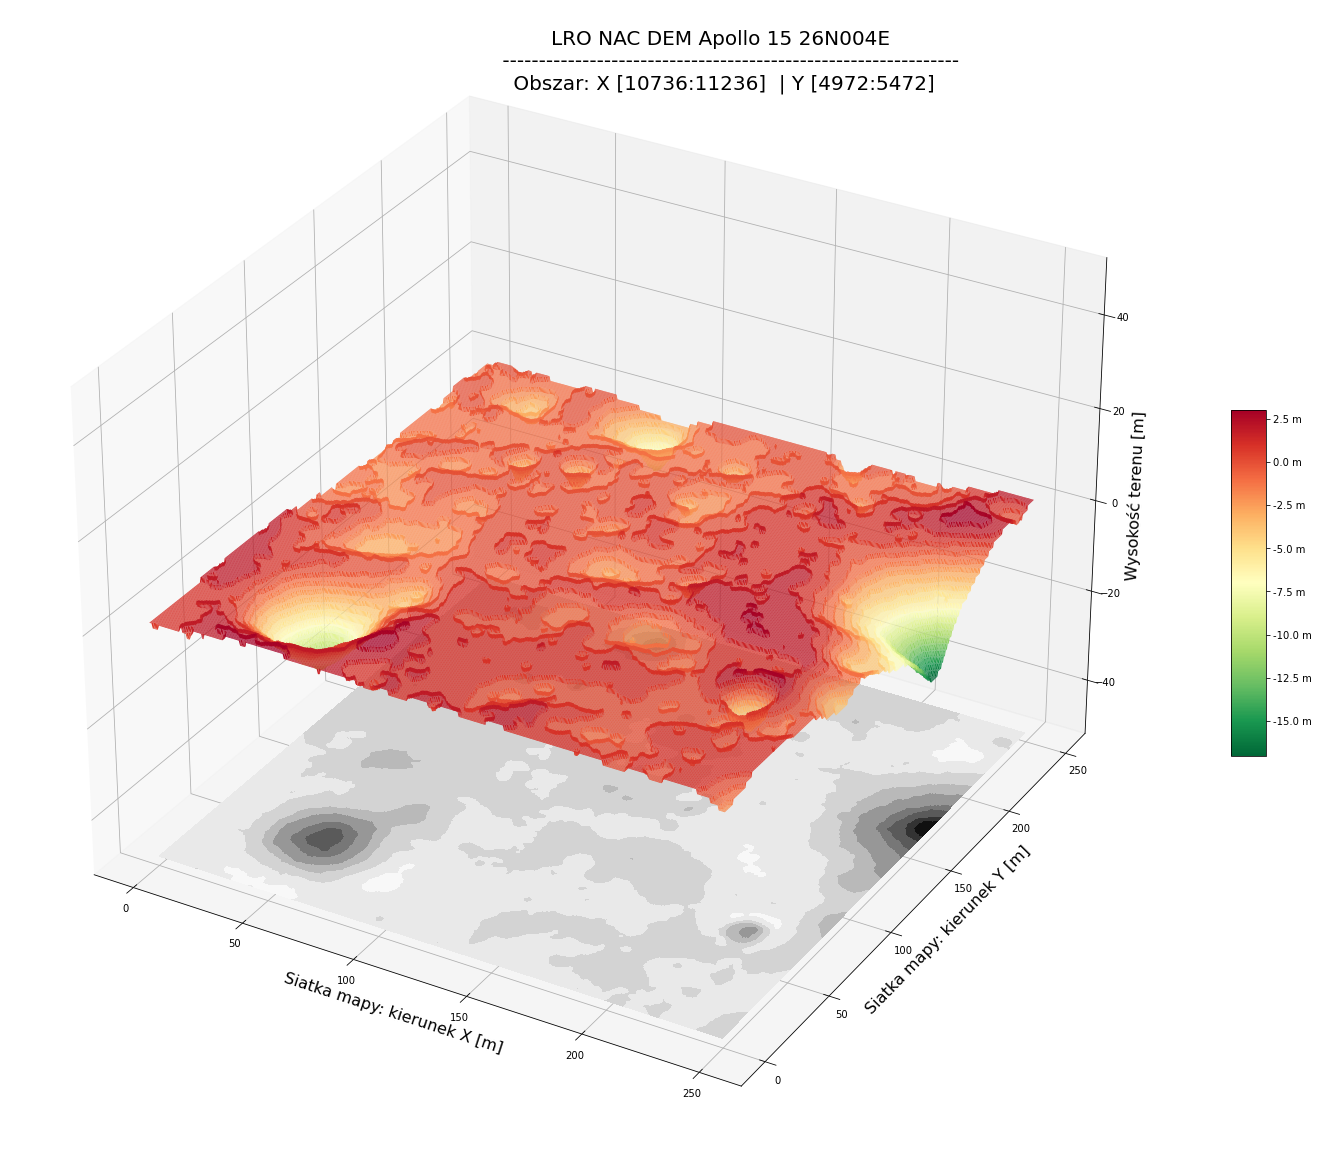

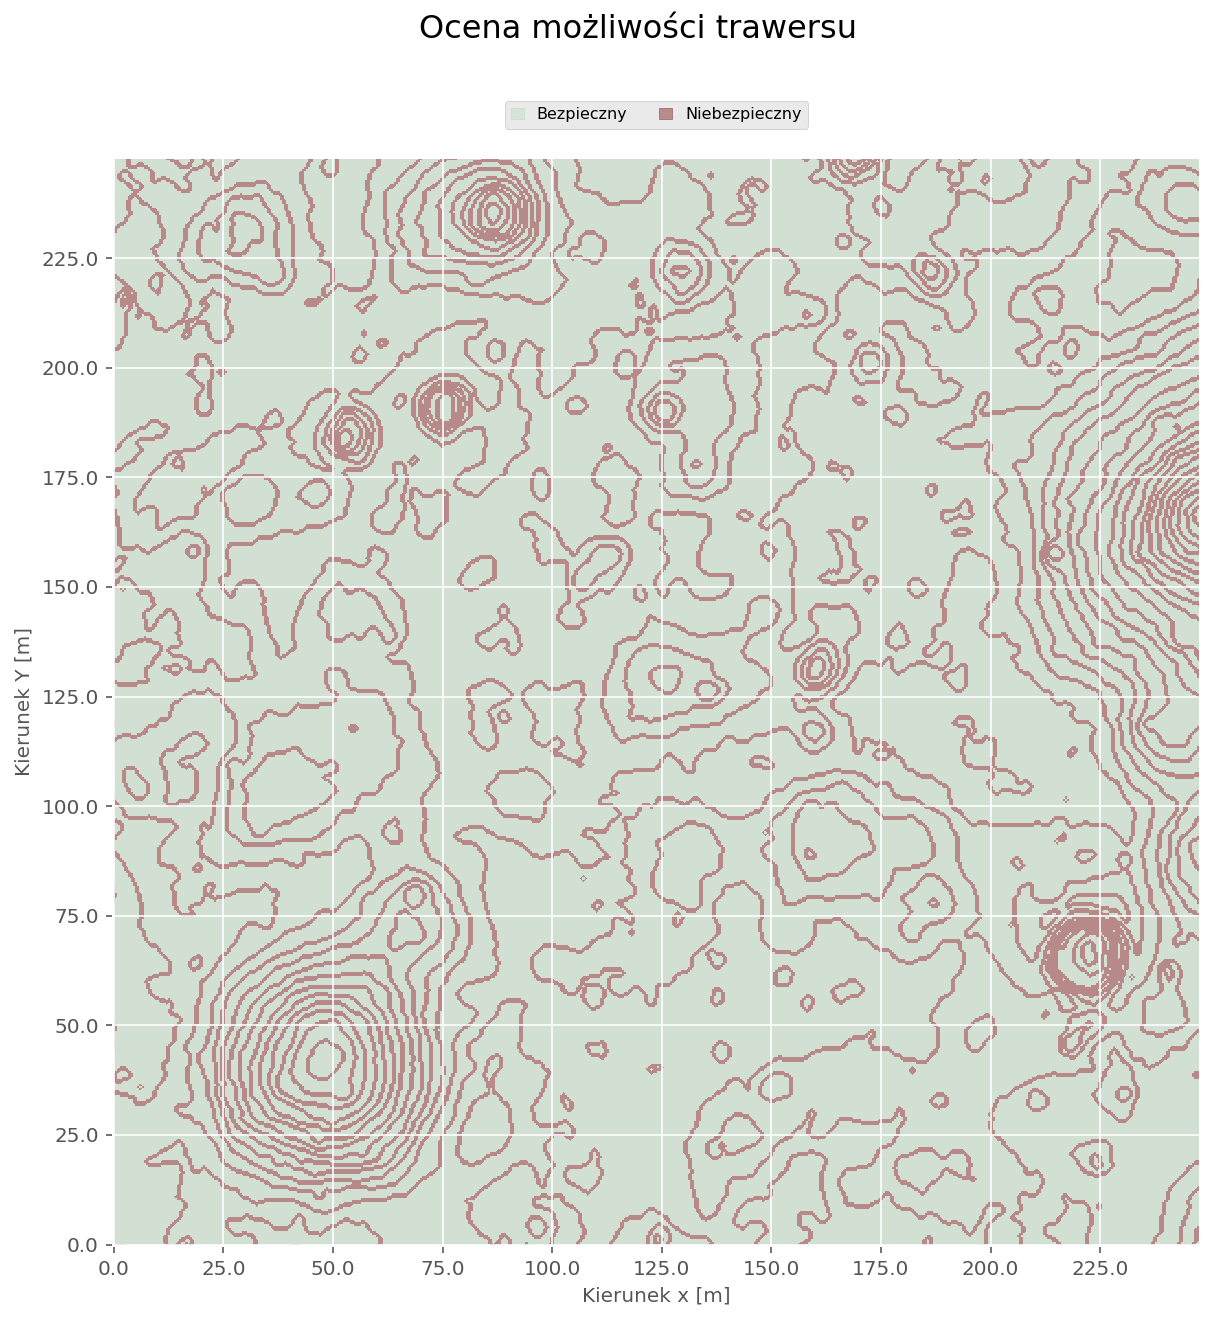

In [11]:
dem_name = save_dem(img, out_path, name='DEM', name_idx=name_idx)
slope = calculate_slope(img)
slope_name = save_dem(slope, out_path, name='SLOPE', name_idx=name_idx)
safe_slope = safe_area(slope)

og_name = save_dem(safe_slope, out_path, name='OG', name_idx=name_idx)
mesh_plot_name = plot_mesh(img, export_img=True, out_path=out_path, name_idx=name_idx, height=50)
slope_plot_name = analyze_slope_map(img, True, out_path=out_path, name_idx=name_idx, step=50)


../dataset/Mapset\S_E_plot_X_10736_11236_Y_4972_5472.jpg


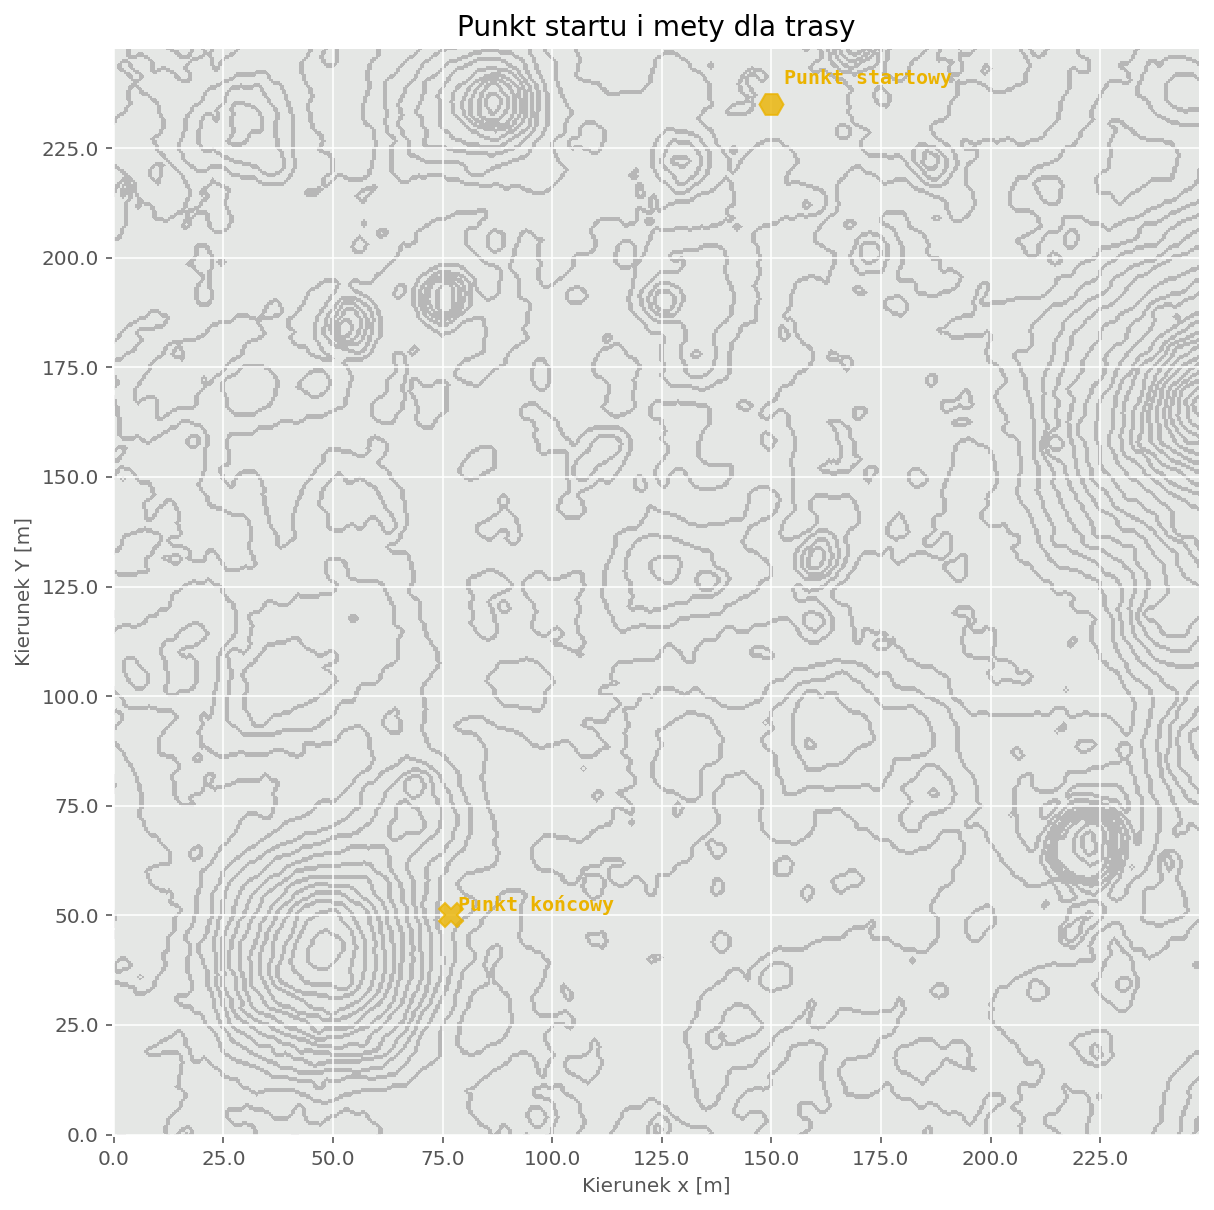

In [12]:
res = 0.5 # [m]
sx = 235.0 / res  # [m]
sy = 150.0 / res  # [m]
gx = 50.0 / res   # [m]
gy = 77.0 / res  # [m]


start_end_name = plot_start_end(safe_slope,(sy,sx),(gy,gx), export_img=True, out_path=out_path, name_idx=name_idx, step=50)

In [13]:
add_test_case = True

In [15]:
if add_test_case:
    append_test_case(test_dict, og_name, dem_name, slope_name, sx, sy, gx, gy, res, name_idx)
    export_test_case_table(test_dict, out_path=out_path,
                           name_idx=name_idx)

../dataset/Mapset\test_table_X_10736_11236_Y_4972_5472.csv
